# Question 2 Random Walk Task

Learned values after 1000 episodes:
  V(A) = 0.118
  V(B) = 0.193
  V(C) = 0.501
  V(D) = 0.748
  V(E) = 0.892


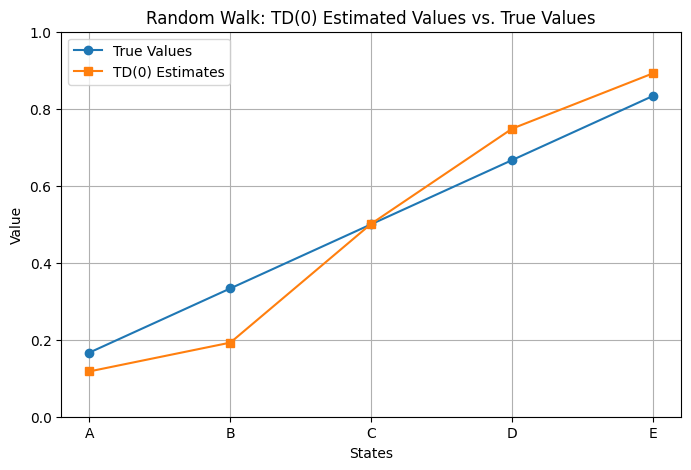

In [107]:
import numpy as np
import matplotlib.pyplot as plt

class RandomWalk:
    def __init__(self):
        """
        Initialize the 5-state Random Walk MRP with states A, B, C, D, E
        and two terminal states: left_terminal, right_terminal.
        
        States are arranged in a line:
        
        [left_terminal] -- A -- B -- C -- D -- E -- [right_terminal]
        
        The agent always starts at state C.
        """
        self.states = ['A', 'B', 'C', 'D', 'E']
        self.terminal_states = ['left_terminal', 'right_terminal']
        self.reset()

    def reset(self):
        """
        Reset the environment to the start state (C).
        Returns:
            str: The initial (start) state.
        """
        self.current_state = 'C'
        return self.current_state

    def step(self, action):
        """
        Take a step in the environment.
        
        Args:
            action (int): -1 for left, +1 for right.

        Returns:
            next_state (str): The next state.
            reward (float): Reward received (1 only if we move into right_terminal).
            done (bool): Whether the episode has ended.
        """
        # If we're already in a terminal state, episode is done
        if self.current_state in self.terminal_states:
            return self.current_state, 0.0, True

        # Find index of current_state in ['A','B','C','D','E']
        idx = self.states.index(self.current_state)

        # Move left or right
        next_idx = idx + action

        # Check if we moved beyond left or right boundary
        if next_idx < 0:
            # Moved into left terminal
            next_state = 'left_terminal'
            reward = 0.0
            done = True
        elif next_idx >= len(self.states):
            # Moved into right terminal
            next_state = 'right_terminal'
            reward = 1.0
            done = True
        else:
            # Moved to another non-terminal state
            next_state = self.states[next_idx]
            reward = 0.0
            done = False

        self.current_state = next_state
        return next_state, reward, done


class TDLearner:
    def __init__(self, alpha=0.1, gamma=1.0):
        """
        Initialize the TD(0) learning algorithm.
        
        Args:
            alpha (float): Learning rate.
            gamma (float): Discount factor.
        """
        self.alpha = alpha
        self.gamma = gamma

        # Initialize value function:
        # States A-E start around 0.5 (as per Example 6.2),
        # Terminal states have fixed values (often 0).
        self.value_function = {}
        for s in ['A', 'B', 'C', 'D', 'E']:
            self.value_function[s] = 0.5
        # Terminal states are often not updated, but we can keep them in the dict
        self.value_function['left_terminal'] = 0.0
        self.value_function['right_terminal'] = 0.0

    def update(self, state, reward, next_state):
        """
        Perform a TD(0) update step.
        
        V(s) <- V(s) + alpha * [r + gamma*V(s') - V(s)]
        """
        # If next_state is terminal, we use V(next_state)=0 or its stored value.
        td_target = reward + self.gamma * self.value_function[next_state]
        td_error = td_target - self.value_function[state]
        self.value_function[state] += self.alpha * td_error


def run_experiment(num_episodes=1000, alpha=0.1):
    """
    Run the Random Walk experiment with TD(0).
    
    Args:
        num_episodes (int): Number of episodes to run.
        alpha (float): Learning rate for TD(0).
    
    Returns:
        dict: The learned value function for each state.
    """
    env = RandomWalk()
    agent = TDLearner(alpha=alpha)

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            # Random left or right action
            action = np.random.choice([-1, 1])
            next_state, reward, done = env.step(action)
            agent.update(state, reward, next_state)
            state = next_state

    return agent.value_function


def plot_results(estimated_values):
    """
    Plot estimated values against the true values from Example 6.2.
    
    True values (for states A, B, C, D, E) are:
        A -> 1/6
        B -> 2/6
        C -> 3/6
        D -> 4/6
        E -> 5/6
    """
    states = ['A', 'B', 'C', 'D', 'E']
    true_values = np.array([1/6, 2/6, 3/6, 4/6, 5/6])
    est_vals = np.array([estimated_values[s] for s in states])

    plt.figure(figsize=(8, 5))
    plt.plot(states, true_values, label='True Values', marker='o')
    plt.plot(states, est_vals, label='TD(0) Estimates', marker='s')
    plt.ylim([0, 1])
    plt.xlabel('States')
    plt.ylabel('Value')
    plt.title('Random Walk: TD(0) Estimated Values vs. True Values')
    plt.legend()
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    # Run experiment
    learned_values = run_experiment(num_episodes=1000, alpha=0.1)

    # Print or inspect learned values
    print("Learned values after 1000 episodes:")
    for s in ['A','B','C','D','E']:
        print(f"  V({s}) = {learned_values[s]:.3f}")

    # Plot the results
    plot_results(learned_values)


# Question 3 and 4 Windy Gridworld Domain

In [108]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [109]:
import numpy as np
import matplotlib.pyplot as plt

class WindyGridWorld(object):
    def __init__(self, enable_king_move=False, enable_no_move=False):
        """
        Windy GridWorld:
            - Grid shape: 7 rows x 10 columns
            - Start state: (3, 0)
            - Goal state:  (3, 7)
            - Wind:        [0,0,0,1,1,1,2,2,1,0] (applied as upward movement)
            - Reward:      -1 each step, 0 at goal
        Args:
            enable_king_move (bool): If True, agent can move in 8 directions.
            enable_no_move   (bool): If True, agent can choose to "stay" in place.
        """
        # Define the grid (7 rows x 10 columns)
        self.grid = np.zeros((7, 10))

        # Define the state space as all valid (row, col) in the grid
        # (Though you might not strictly need this list)
        self.state_space = [
            [r, c] for r in range(self.grid.shape[0])
                    for c in range(self.grid.shape[1])
        ]

        # Define start and goal states
        self.start_state = [3, 0]
        self.goal_state = [3, 7]

        # Define wind strength per column (upward movement)
        self.wind = np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0], dtype=int)

        # Define possible actions
        if enable_king_move:
            # 8 directions (King's moves)
            moves = {
                "up":         np.array([-1,  0]),
                "down":       np.array([ 1,  0]),
                "left":       np.array([ 0, -1]),
                "right":      np.array([ 0,  1]),
                "up-left":    np.array([-1, -1]),
                "up-right":   np.array([-1,  1]),
                "down-left":  np.array([ 1, -1]),
                "down-right": np.array([ 1,  1])
            }
            # Optionally add "stay in place"
            if enable_no_move:
                moves["stay"] = np.array([0, 0])
            self.action_space = moves
        else:
            # Standard 4 directions
            self.action_space = {
                "up":    np.array([-1, 0]),
                "down":  np.array([ 1, 0]),
                "left":  np.array([ 0,-1]),
                "right": np.array([ 0, 1])
            }

        # Track the current state, time step, and last action
        self.state = None
        self.t = None
        self.act = None

    def reset(self):
        """
        Resets the agent to the start state and returns (state, terminated).
        """
        self.state = self.start_state.copy()
        self.t = 0
        self.act = None
        terminated = False
        return self.state, terminated

    def step(self, act_key):
        """
        Takes a step in the environment given an action key (e.g. 'up', 'down', etc.).
        
        Args:
            act_key (str): One of the keys in self.action_space.

        Returns:
            next_state (list): [row, col]
            reward (float):    -1 each step, 0 if goal is reached
            terminated (bool): True if next_state is the goal state
        """
        # Record the chosen action key (for rendering/debug)
        self.act = act_key

        # Get the shift from the action space
        shift = self.action_space[act_key]

        # 1) Move according to the chosen action
        next_r = self.state[0] + shift[0]
        next_c = self.state[1] + shift[1]

        # 2) Apply wind (upward shift) based on the *column* of the current state
        wind_strength = self.wind[self.state[1]]
        next_r -= wind_strength

        # 3) Clip to grid boundaries
        max_r, max_c = self.grid.shape
        next_r = max(0, min(next_r, max_r - 1))
        next_c = max(0, min(next_c, max_c - 1))

        # Update the state
        self.state = [next_r, next_c]

        # Check if we reached the goal
        terminated = (self.state == self.goal_state)

        # Typical reward scheme: -1 per step, 0 upon reaching goal
        reward = 0.0 if terminated else -1.0

        self.t += 1
        return self.state, reward, terminated

    def render(self):
        """
        Render the current state of the environment.
        - 0 = empty
        - 1 = agent
        - 2 = goal
        """
        # Make a copy of the base grid
        plot_arr = self.grid.copy()
        # Place agent
        plot_arr[self.state[0], self.state[1]] = 1.0
        # Place goal
        plot_arr[self.goal_state[0], self.goal_state[1]] = 2.0

        # Simple visualization
        plt.clf()
        fig, ax = plt.subplots(1, 1)
        ax.set_title(f"State={self.state}, Action={self.act}")
        ax.imshow(plot_arr, origin='upper')
        plt.show(block=False)
        plt.pause(1)   # Pause so we can see the plot
        plt.close(fig)


<Figure size 640x480 with 0 Axes>

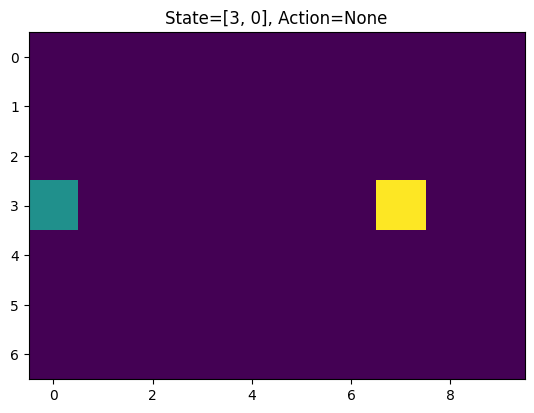

In [125]:
env = WindyGridWorld(enable_king_move=False, enable_no_move=False)
env.reset()
env.render()

In [110]:
class SARSA(object):
    def __init__(self, env, alpha, epsilon, gamma, timeout):
        """
        SARSA agent for a discrete environment.

        Args:
            env:        The environment (with .state_space, .action_space, .reset(), .step()).
            alpha:      Learning rate.
            epsilon:    Exploration rate (for epsilon-greedy).
            gamma:      Discount factor.
            timeout:    Max steps per episode before forcing termination.
        """
        self.env = env
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.timeout = timeout

        # Number of states and actions
        self.state_num = len(self.env.state_space)
        # Convert the dict keys to a list for stable indexing
        self.actions = list(self.env.action_space.keys())
        self.action_num = len(self.actions)

        # Initialize Q(s, a) to 0 (or small random values)
        self.Q = np.zeros((self.state_num, self.action_num))

    def _state_to_index(self, state):
        """Convert a [row, col] state to an integer index."""
        return self.env.state_space.index(state)

    def behavior_policy(self, state):
        """
        Epsilon-greedy policy over Q(s, .).
        Returns an action index.
        """
        s_idx = self._state_to_index(state)

        # With probability epsilon, choose a random action
        if np.random.rand() < self.epsilon:
            a_idx = np.random.choice(self.action_num)
        else:
            # Otherwise choose the action that maximizes Q(s,a)
            a_idx = np.argmax(self.Q[s_idx, :])
        return a_idx

    def update(self, s, a_idx, r, s_prime, a_prime_idx):
        """
        Perform the SARSA update:
          Q(s,a) <- Q(s,a) + alpha * [r + gamma * Q(s',a') - Q(s,a)]
        """
        s_idx = self._state_to_index(s)
        s_prime_idx = self._state_to_index(s_prime)

        td_target = r + self.gamma * self.Q[s_prime_idx, a_prime_idx]
        td_error = td_target - self.Q[s_idx, a_idx]
        self.Q[s_idx, a_idx] += self.alpha * td_error

    def rollout(self):
        """
        Play one episode using SARSA, until termination or timeout.
        Returns:
            steps (int): Number of steps taken in this episode.
        """
        state, terminated = self.env.reset()

        # Choose an initial action using behavior_policy
        a_idx = self.behavior_policy(state)

        steps = 0
        while not terminated and steps < self.timeout:
            # Convert the action index back to the environment's action key
            action_key = self.actions[a_idx]

            # Take a step in the environment
            next_state, reward, terminated = self.env.step(action_key)

            # Choose next action
            a_prime_idx = self.behavior_policy(next_state)

            # SARSA update
            self.update(state, a_idx, reward, next_state, a_prime_idx)

            # Move on
            state = next_state
            a_idx = a_prime_idx
            steps += 1

        return steps

    def run(self, num_episodes=500):
        """
        Run multiple episodes of SARSA.
        Returns:
            steps_per_episode (list): The number of steps taken in each episode.
        """
        steps_per_episode = []
        for ep in range(num_episodes):
            steps = self.rollout()
            steps_per_episode.append(steps)
        return steps_per_episode


In [111]:
class MonteCarlo(object):
    def __init__(self, env, epsilon, gamma, num_episodes, timeout=10000):
        """
        Monte Carlo agent for on-policy first-visit MC control.

        Args:
            env: The environment, which should have methods:
                 - reset() that returns (state, done)
                 - step(state, action) that returns (next_state, reward, done)
                 - action_space: a list or dict of possible actions (e.g., 9 possible increments)
            epsilon: Exploration rate for the ε–greedy policy.
            gamma: Discount factor.
            num_episodes: Number of episodes to run.
            timeout: Maximum steps per episode to prevent infinite loops.
        """
        self.env = env
        self.epsilon = epsilon
        self.gamma = gamma
        self.num_episodes = num_episodes
        self.timeout = timeout
        
        # Q maps (state, action) -> value.
        self.Q = {}
        # Count for first-visit updates (used to compute incremental averages).
        self.returns_count = {}
        
        # If the action_space is a dict, convert it to a list of keys.
        if isinstance(self.env.action_space, dict):
            self.action_space = list(self.env.action_space.keys())
        else:
            self.action_space = self.env.action_space
        
        # Precompute state indices for faster lookups
        self.state_to_idx = {}
        for idx, state in enumerate(self.env.state_space):
            self.state_to_idx[tuple(state)] = idx

    def behavior_policy(self, state):
        """
        ε–greedy policy: Given a state, return an action sampled from an ε–soft policy.
        
        Args:
            state (list or array): The current state.

        Returns:
            action: An action chosen from self.action_space.
        """
        state_key = tuple(state)
        q_vals = []
        for a in self.action_space:
            # If the action is a numpy array or list, convert it to a tuple for dictionary lookup.
            if isinstance(a, (np.ndarray, list)):
                a_key = tuple(a)
            else:
                a_key = a  # e.g., if a is a string like "up"
            q_vals.append(self.Q.get((state_key, a_key), 0.0))
        q_vals = np.array(q_vals)
        max_q = np.max(q_vals)
        # Find all greedy actions (if multiple actions have the same max Q, all are considered greedy)
        greedy_indices = np.where(q_vals == max_q)[0]
        # Create a probability distribution: with probability epsilon, choose uniformly at random;
        # with probability (1 - epsilon) choose uniformly among greedy actions.
        probs = np.full(len(self.action_space), self.epsilon / len(self.action_space))
        for idx in greedy_indices:
            probs[idx] += (1 - self.epsilon) / len(greedy_indices)
        chosen_idx = np.random.choice(len(self.action_space), p=probs)
        return self.action_space[chosen_idx]

    def update(self, transitions):
        """
        Perform first-visit MC updates based on an episode's transitions.
        
        Args:
            transitions (list): A list of (state, action, reward) tuples collected during an episode.
        """
        visited_sa = set()
        G_so_far = 0.0
        # Traverse the episode in reverse order.
        for t in reversed(range(len(transitions))):
            s_t, a_t, r_t = transitions[t]
            G_so_far = self.gamma * G_so_far + r_t
            s_key = tuple(s_t)
            # Use action directly if it is a string or already a proper key.
            if isinstance(a_t, (np.ndarray, list)):
                a_key = tuple(a_t)
            else:
                a_key = a_t
            # First visit of the state-action pair in this episode.
            if (s_key, a_key) not in visited_sa:
                visited_sa.add((s_key, a_key))
                self.returns_count[(s_key, a_key)] = self.returns_count.get((s_key, a_key), 0) + 1
                old_Q = self.Q.get((s_key, a_key), 0.0)
                # Incremental mean update.
                self.Q[(s_key, a_key)] = old_Q + (G_so_far - old_Q) / self.returns_count[(s_key, a_key)]

    def rollout(self):
        """
        Generate one episode using the current policy, perform MC updates on Q,
        and return the number of steps in the episode.

        Returns:
            steps (int): The number of steps taken in the episode.
        """
        transitions = []
        state, done = self.env.reset()  # reset returns (state, done)
        steps = 0
        
        # Add timeout condition to prevent infinite loops
        while not done and steps < self.timeout:
            action = self.behavior_policy(state)
            next_state, reward, done = self.env.step(action)
            transitions.append((state, action, reward))
            state = next_state
            steps += 1

        # Only update if we collected some transitions
        if transitions:
            # Perform first-visit MC updates.
            self.update(transitions)
        
        return steps

    def run(self):
        """
        Run multiple episodes of on-policy first-visit Monte Carlo control.

        Returns:
            steps_per_episode (list): A list of steps per episode.
        """
        steps_per_episode = []
        for ep in range(self.num_episodes):
            steps = self.rollout()
            steps_per_episode.append(steps)
            
            # For debugging
            if ep % 10 == 0:
                print(f"Monte Carlo Episode {ep}: {steps} steps")
                
        return steps_per_episode


In [112]:
class ExpectedSARSA(object):
    def __init__(self, env, alpha, epsilon, gamma, timeout):
        """
        Expected SARSA agent for discrete environments.

        Args:
            env: An environment with attributes:
                 - state_space: a list of all states.
                 - action_space: a dict of actions (keys are action names, values are action definitions).
                 - reset() and step(action) methods.
            alpha: Learning rate.
            epsilon: Exploration rate for ε–greedy policy.
            gamma: Discount factor.
            timeout: Maximum steps per episode.
        """
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.env = env

        # Create a stable ordering of states and actions for indexing.
        self.state_num = len(self.env.state_space)
        self.actions = list(self.env.action_space.keys())
        self.action_num = len(self.actions)

        # Initialize Q–table as a NumPy array: rows correspond to states, columns to actions.
        self.Q = np.zeros((self.state_num, self.action_num))

        # Timeout for an episode
        self.timeout = timeout

    def _state_to_index(self, state):
        """
        Convert a state (assumed to be in the same format as in env.state_space) to its index.
        """
        return self.env.state_space.index(state)

    def behavior_policy(self, state):
        """
        ε–greedy policy: Given a state, return an action index using an ε–greedy rule.
        """
        s_idx = self._state_to_index(state)
        if np.random.rand() < self.epsilon:
            a_idx = np.random.choice(self.action_num)
        else:
            a_idx = np.argmax(self.Q[s_idx])
        return a_idx

    def expected_value(self, s_prime):
        """
        Compute the expected value of Q(s_prime, .) under the ε–greedy policy.

        This is computed as:
            Σ_a π(a|s_prime) * Q(s_prime, a)
        where π is the ε–greedy policy.
        """
        s_idx = self._state_to_index(s_prime)
        q_vals = self.Q[s_idx]
        max_q = np.max(q_vals)
        # Identify all greedy actions (in case of ties)
        greedy_indices = np.where(q_vals == max_q)[0]
        # Build the probability distribution: 
        # Each action gets a baseline probability of epsilon/num_actions.
        probs = np.full(self.action_num, self.epsilon / self.action_num)
        # Greedy actions get an additional probability mass of (1 - epsilon)/#(greedy actions)
        for idx in greedy_indices:
            probs[idx] += (1 - self.epsilon) / len(greedy_indices)
        # Expected value is the dot product of probabilities and Q–values.
        expected_q = np.dot(probs, q_vals)
        return expected_q

    def update(self, s, a_idx, r, s_prime, a_prime=None):
        """
        Expected SARSA update:
            Q(s,a) <- Q(s,a) + alpha * [r + gamma * E_a'[Q(s', a')] - Q(s,a)]
        
        Args:
            s: Current state.
            a_idx: Action index taken in state s.
            r: Reward received.
            s_prime: Next state.
            a_prime: Not used in Expected SARSA.
        """
        s_idx = self._state_to_index(s)
        expected_q = self.expected_value(s_prime)
        td_target = r + self.gamma * expected_q
        td_error = td_target - self.Q[s_idx, a_idx]
        self.Q[s_idx, a_idx] += self.alpha * td_error

    def rollout(self):
        """
        Generate one episode using the current policy and perform Expected SARSA updates.

        Returns:
            steps (int): Number of steps taken in this episode.
        """
        state, _ = self.env.reset()  # Assumes reset returns (state, terminated)
        terminated = False
        steps = 0

        while not terminated and steps < self.timeout:
            # Choose an action index using the ε–greedy behavior policy.
            a_idx = self.behavior_policy(state)
            # Map the action index back to the environment's action key.
            action_key = self.actions[a_idx]
            next_state, reward, terminated = self.env.step(action_key)

            # Update Q using Expected SARSA (note: no explicit next action is used).
            self.update(state, a_idx, reward, next_state)
            state = next_state
            steps += 1

        return steps

    def run(self, num_episodes=500):
        """
        Run Expected SARSA for a given number of episodes.

        Returns:
            steps_per_episode (list): Number of steps per episode.
        """
        steps_per_episode = []
        for ep in range(num_episodes):
            steps = self.rollout()
            steps_per_episode.append(steps)
        return steps_per_episode


In [113]:
class QLearning(object):
    def __init__(self, env, alpha, epsilon, gamma, timeout):
        """
        Q-Learning agent for discrete environments.
        
        Args:
            env: The environment, assumed to have:
                 - state_space: a list of states.
                 - action_space: a dict of actions (e.g., {"up": ..., "down": ...})
                 - reset() and step(action) methods.
            alpha: Learning rate.
            epsilon: Exploration rate for ε–greedy policy.
            gamma: Discount factor.
            timeout: Maximum steps per episode.
        """
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.env = env

        # Create stable indexing for states and actions
        self.state_num = len(self.env.state_space)
        self.actions = list(self.env.action_space.keys())
        self.action_num = len(self.actions)

        # Initialize Q–table: rows for states, columns for actions.
        self.Q = np.zeros((self.state_num, self.action_num))

        # Timeout (max steps per episode)
        self.timeout = timeout

    def _state_to_index(self, state):
        """
        Helper method: convert a state (assumed to be in env.state_space) into its index.
        """
        return self.env.state_space.index(state)

    def behavior_policy(self, state):
        """
        ε–greedy policy: Given a state, return an action index.
        
        With probability ε, returns a random action index; otherwise returns the index of the action
        with the highest Q–value.
        """
        s_idx = self._state_to_index(state)
        if np.random.rand() < self.epsilon:
            a_idx = np.random.choice(self.action_num)
        else:
            a_idx = np.argmax(self.Q[s_idx])
        return a_idx

    def update(self, s, a_idx, r, s_prime):
        """
        Perform the Q-Learning update:
        
            Q(s,a) <- Q(s,a) + alpha * [r + gamma * max_a' Q(s',a') - Q(s,a)]
        
        Args:
            s: Current state.
            a_idx: Action index taken in state s.
            r: Reward received.
            s_prime: Next state.
        """
        s_idx = self._state_to_index(s)
        s_prime_idx = self._state_to_index(s_prime)
        best_next_q = np.max(self.Q[s_prime_idx])
        td_target = r + self.gamma * best_next_q
        td_error = td_target - self.Q[s_idx, a_idx]
        self.Q[s_idx, a_idx] += self.alpha * td_error

    def rollout(self):
        """
        Generate one episode using the current policy and perform Q-learning updates.
        
        Returns:
            steps (int): Number of steps taken in this episode.
        """
        state, terminated = self.env.reset()
        steps = 0
        
        while not terminated and steps < self.timeout:
            a_idx = self.behavior_policy(state)
            action_key = self.actions[a_idx]
            next_state, reward, terminated = self.env.step(action_key)
            self.update(state, a_idx, reward, next_state)
            state = next_state
            steps += 1
        
        return steps

    def run(self, num_episodes=500):
        """
        Run Q-Learning for a given number of episodes.
        
        Returns:
            steps_per_episode (list): The number of steps taken in each episode.
        """
        steps_per_episode = []
        for ep in range(num_episodes):
            steps = self.rollout()
            steps_per_episode.append(steps)
        return steps_per_episode


In [114]:
def plot_sutton_style(run_results, legend_list, color_list, max_steps=80000):
    """
    Create a plot in the style of Figure 6.5 in Sutton & Barto.
    
    Args:
        run_results: A list of results arrays, each containing steps per episode
        legend_list: List of names for each algorithm
        color_list: List of colors for each algorithm
        max_steps: Maximum steps to show on x-axis
    """
    plt.figure(figsize=(10, 6))
    
    # For each algorithm's results
    for i, results_array in enumerate(run_results):
        # Handle NaN values when computing statistics
        avg_results = np.nanmean(results_array, axis=0)
        
        # Compute standard error (careful with NaN values)
        valid_counts = np.sum(~np.isnan(results_array), axis=0)
        valid_counts = np.maximum(valid_counts, 1)  # Avoid division by zero
        se = np.nanstd(results_array, axis=0) / np.sqrt(valid_counts)
        
        # Replace NaN values in avg_results with the last valid value
        # This is important for algorithms that terminate early
        last_valid = 0
        for j in range(len(avg_results)):
            if np.isnan(avg_results[j]):
                avg_results[j] = last_valid
            else:
                last_valid = avg_results[j]
        
        # Convert steps per episode to cumulative steps and episodes
        cum_steps = np.cumsum(avg_results)
        episodes = np.arange(1, len(cum_steps) + 1)
        
        # Clip to max_steps for consistent x-axis
        mask = cum_steps <= max_steps
        if not np.any(mask):  # If all steps are beyond max_steps
            # Take just the first point for reference
            plt.plot([0, cum_steps[0]], [0, 1], color=color_list[i], label=legend_list[i])
        else:
            # Ensure we include the last point that exceeds max_steps
            if np.sum(mask) < len(mask) and np.sum(mask) > 0:
                last_idx = np.where(mask)[0][-1] + 1
                if last_idx < len(mask):
                    mask[last_idx] = True
                    
            # Only plot up to the maximum valid episode
            valid_episodes = np.sum(valid_counts > 0)
            if valid_episodes < len(mask):
                mask = mask & (np.arange(len(mask)) < valid_episodes)
            
            # Plot episodes vs. cumulative steps
            plt.plot(cum_steps[mask], episodes[mask], color=color_list[i], label=legend_list[i])
            
            # Add confidence intervals (optional)
            if len(results_array) > 1:  # Only if we have multiple runs
                cum_steps_upper = np.cumsum(np.minimum(avg_results + 1.96 * se, 2 * avg_results))  # Cap at 2x avg to avoid extreme outliers
                cum_steps_lower = np.cumsum(np.maximum(avg_results - 1.96 * se, 0.5 * avg_results))  # Floor at 0.5x avg
                
                # Clip to same range
                cum_steps_upper = cum_steps_upper[mask]
                cum_steps_lower = cum_steps_lower[mask]
                episodes_masked = episodes[mask]
                
                plt.fill_between(
                    cum_steps[mask],
                    episodes_masked,
                    episodes_masked,
                    alpha=0.2,
                    color=color_list[i]
                )
    
    plt.xlabel('Time steps')
    plt.ylabel('Episodes')
    plt.title('Windy Gridworld')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [115]:
def run_on_policy_td_control(run_num, max_steps=80000,timeout=10000):
    """
    Run multiple TD control algorithms and plot results in Sutton & Barto style.
    
    Args:
        run_num: Number of independent runs for each algorithm
        max_steps: Maximum number of cumulative steps to display
    """
    enable_king_move_actions = False
    enable_no_move_actions = False

    # Initialize results storage
    sarsa_results = []
    expected_sarsa_results = []
    q_learning_results = []
    montecarlo_results = []
    
    # Parameters
    num_episodes = 200  # More than enough to reach max_steps
    epsilon = 0.1
    alpha = 0.5
    gamma = 1.0
    
    print("Starting algorithm evaluation...")
    
    # Run multiple trials
    for run in range(run_num):
        print(f"Run {run+1}/{run_num}")
        
        # Create a new environment for each algorithm to ensure fair comparison
        env = WindyGridWorld(enable_king_move=enable_king_move_actions,
                             enable_no_move=enable_no_move_actions)
        
        # SARSA
        print(f"  Running SARSA...")
        controller_sarsa = SARSA(env, alpha, epsilon, gamma, timeout)
        steps_per_episode = controller_sarsa.run(num_episodes)
        sarsa_results.append(steps_per_episode)
        
        # Expected SARSA
        print(f"  Running Expected SARSA...")
        env = WindyGridWorld(enable_king_move=enable_king_move_actions,
                             enable_no_move=enable_no_move_actions)
        controller_expected_sarsa = ExpectedSARSA(env, alpha, epsilon, gamma, timeout)
        steps_per_episode = controller_expected_sarsa.run(num_episodes)
        expected_sarsa_results.append(steps_per_episode)
        
        # Q-Learning
        print(f"  Running Q-Learning...")
        env = WindyGridWorld(enable_king_move=enable_king_move_actions,
                             enable_no_move=enable_no_move_actions)
        controller_q_learning = QLearning(env, alpha, epsilon, gamma, timeout)
        steps_per_episode = controller_q_learning.run(num_episodes)
        q_learning_results.append(steps_per_episode)
        
        # Monte Carlo with explicit timeout
        print(f"  Running Monte Carlo...")
        env = WindyGridWorld(enable_king_move=enable_king_move_actions,
                             enable_no_move=enable_no_move_actions)
        controller_mc = MonteCarlo(env, epsilon, gamma, num_episodes, timeout)
        steps_per_episode = controller_mc.run()
        montecarlo_results.append(steps_per_episode)
    
    # Print summary statistics
    print("\nAverage steps per episode in first 10 episodes:")
    print(f"  SARSA: {np.mean([r[:10] for r in sarsa_results]):.2f}")
    print(f"  Expected SARSA: {np.mean([r[:10] for r in expected_sarsa_results]):.2f}")
    print(f"  Q-Learning: {np.mean([r[:10] for r in q_learning_results]):.2f}")
    print(f"  Monte Carlo: {np.mean([r[:10] for r in montecarlo_results]):.2f}")
    
    # Convert to numpy arrays with padding to handle different lengths
    max_length = max(
        max(len(r) for r in sarsa_results),
        max(len(r) for r in expected_sarsa_results),
        max(len(r) for r in q_learning_results),
        max(len(r) for r in montecarlo_results)
    )
    
    def pad_array(arr, length):
        padded = []
        for r in arr:
            if len(r) < length:
                padded.append(np.pad(r, (0, length - len(r)), 'constant', constant_values=np.nan))
            else:
                padded.append(r[:length])
        return np.array(padded)
    
    sarsa_array = pad_array(sarsa_results, max_length)
    expected_sarsa_array = pad_array(expected_sarsa_results, max_length)
    q_learning_array = pad_array(q_learning_results, max_length)
    montecarlo_array = pad_array(montecarlo_results, max_length)
    
    print("\nGenerating plot...")
    
    # Plot in Sutton & Barto style
    plot_sutton_style(
        [sarsa_array, expected_sarsa_array, q_learning_array, montecarlo_array],
        ['SARSA', 'Expected SARSA', 'Q-learning', 'Monte Carlo'],
        ['r', 'b', 'g', 'm'],
        max_steps
    )


In [116]:
# Set random seeds
np.random.seed(1234)
random.seed(1234)

# Set to a smaller number of runs for quicker results
run_num = 5  # Number of independent runs (reduced for speed)
max_steps = 16000  # Maximum number of steps to display

# Just checking if MC is terminating
env = WindyGridWorld(enable_king_move=False, enable_no_move=False)
mc = MonteCarlo(env, epsilon=0.1, gamma=1.0, num_episodes=10, timeout=10000)
steps = mc.run()
print(f"Monte Carlo test run completed with steps per episode: {steps}")


Monte Carlo Episode 0: 599 steps
Monte Carlo test run completed with steps per episode: [599, 10000, 2811, 650, 3865, 1145, 4978, 4762, 9224, 10000]


Starting algorithm evaluation...
Run 1/5
  Running SARSA...
  Running Expected SARSA...
  Running Q-Learning...
  Running Monte Carlo...
Monte Carlo Episode 0: 1000 steps
Monte Carlo Episode 10: 1000 steps
Monte Carlo Episode 20: 1000 steps
Monte Carlo Episode 30: 1000 steps
Monte Carlo Episode 40: 1000 steps
Monte Carlo Episode 50: 1000 steps
Monte Carlo Episode 60: 1000 steps
Monte Carlo Episode 70: 1000 steps
Monte Carlo Episode 80: 1000 steps
Monte Carlo Episode 90: 1000 steps
Monte Carlo Episode 100: 1000 steps
Monte Carlo Episode 110: 1000 steps
Monte Carlo Episode 120: 1000 steps
Monte Carlo Episode 130: 1000 steps
Monte Carlo Episode 140: 1000 steps
Monte Carlo Episode 150: 1000 steps
Monte Carlo Episode 160: 1000 steps
Monte Carlo Episode 170: 1000 steps
Monte Carlo Episode 180: 1000 steps
Monte Carlo Episode 190: 1000 steps
Run 2/5
  Running SARSA...
  Running Expected SARSA...
  Running Q-Learning...
  Running Monte Carlo...
Monte Carlo Episode 0: 1000 steps
Monte Carlo Epis

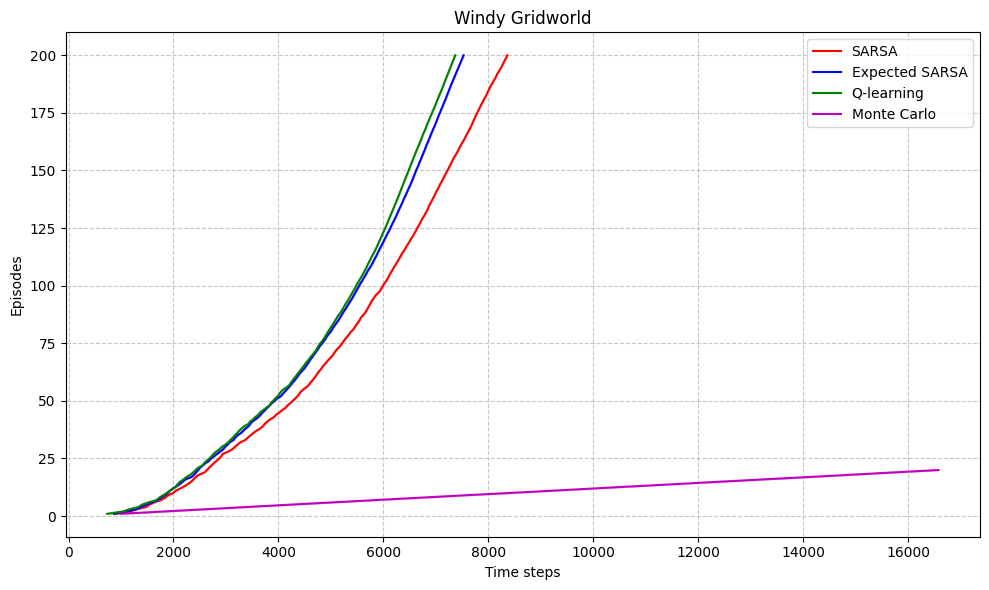

In [117]:
run_on_policy_td_control(run_num, max_steps,timeout=1000)

In [118]:
def run_td_method_comparison(run_num=5, max_steps=16000):
    """
    Compare the three TD methods (SARSA, Expected SARSA, Q-learning) 
    across the three movement configurations:
    1. Standard 4 actions
    2. King's moves (8 actions)
    3. King's moves + stay action (9 actions)
    """
    # Set random seeds for reproducibility
    np.random.seed(1234)
    random.seed(1234)
    
    # Parameters
    num_episodes = 200
    epsilon = 0.1
    alpha = 0.5
    gamma = 1.0
    timeout = 1000
    
    # Initialize results storage for each configuration and algorithm
    configs = [
        {"name": "Standard 4 actions", "king": False, "stay": False},
        {"name": "King's moves (8 actions)", "king": True, "stay": False},
        {"name": "King's moves + stay (9 actions)", "king": True, "stay": True}
    ]
    
    algorithms = [
        {"name": "SARSA", "class": SARSA, "color": "r"},
        {"name": "Expected SARSA", "class": ExpectedSARSA, "color": "b"},
        {"name": "Q-learning", "class": QLearning, "color": "g"}
    ]
    
    # Track all results
    all_results = {}
    
    # Run experiments for each configuration
    for config in configs:
        print(f"\n--- Configuration: {config['name']} ---")
        config_key = config['name']
        all_results[config_key] = {}
        
        # Run each algorithm
        for algo in algorithms:
            print(f"  Running {algo['name']}...")
            algo_results = []
            
            for run in range(run_num):
                print(f"    Run {run+1}/{run_num}")
                env = WindyGridWorld(enable_king_move=config['king'], enable_no_move=config['stay'])
                controller = algo['class'](env, alpha, epsilon, gamma, timeout)
                steps_per_episode = controller.run(num_episodes)
                algo_results.append(steps_per_episode)
            
            all_results[config_key][algo['name']] = algo_results
    
    # Print summary statistics for each configuration
    print("\n=== Performance Summary ===")
    for config_key, config_results in all_results.items():
        print(f"\nConfiguration: {config_key}")
        print("Average steps in episodes 90-100:")
        
        for algo_name, algo_results in config_results.items():
            late_steps = np.mean([r[90:100] for r in algo_results if len(r) >= 100])
            print(f"  {algo_name}: {late_steps:.2f}")
    
    # Plot the results for each configuration
    for config_idx, (config_key, config_results) in enumerate(all_results.items()):
        plt.figure(figsize=(10, 6))
        
        for algo in algorithms:
            algo_name = algo['name']
            results_array = np.array(config_results[algo_name])
            
            # Handle NaN values when computing statistics
            avg_results = np.nanmean(results_array, axis=0)
            
            # Replace NaN values with the last valid value
            last_valid = 0
            for j in range(len(avg_results)):
                if np.isnan(avg_results[j]):
                    avg_results[j] = last_valid
                else:
                    last_valid = avg_results[j]
            
            # Convert steps per episode to cumulative steps and episodes
            cum_steps = np.cumsum(avg_results)
            episodes = np.arange(1, len(cum_steps) + 1)
            
            # Clip to max_steps for consistent x-axis
            mask = cum_steps <= max_steps
            if np.any(mask):
                plt.plot(cum_steps[mask], episodes[mask], color=algo['color'], label=algo_name)
        
        plt.xlabel('Time steps')
        plt.ylabel('Episodes')
        plt.title(f'Windy Gridworld - {config_key}')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    
    # Additional plot: Best method for each configuration
    plt.figure(figsize=(12, 7))
    markers = ['o', '^', 's']
    linestyles = ['-', '--', '-.']
    
    for config_idx, (config_key, config_results) in enumerate(all_results.items()):
        # Find the best performing algorithm for this configuration
        best_algo = None
        best_perf = float('inf')
        
        for algo_name, algo_results in config_results.items():
            late_steps = np.mean([r[90:100] for r in algo_results if len(r) >= 100])
            if late_steps < best_perf:
                best_perf = late_steps
                best_algo = algo_name
        
        # Plot the best algorithm for this configuration
        results_array = np.array(config_results[best_algo])
        avg_results = np.nanmean(results_array, axis=0)
        
        # Replace NaN values
        last_valid = 0
        for j in range(len(avg_results)):
            if np.isnan(avg_results[j]):
                avg_results[j] = last_valid
            else:
                last_valid = avg_results[j]
        
        cum_steps = np.cumsum(avg_results)
        episodes = np.arange(1, len(cum_steps) + 1)
        
        mask = cum_steps <= max_steps
        if np.any(mask):
            plt.plot(
                cum_steps[mask], 
                episodes[mask], 
                linestyle=linestyles[config_idx % len(linestyles)],
                marker=markers[config_idx % len(markers)],
                markevery=max(1, len(cum_steps[mask]) // 10),
                label=f"{config_key} - {best_algo}",
            )
    
    plt.xlabel('Time steps')
    plt.ylabel('Episodes')
    plt.title('Windy Gridworld - Best Method Comparison')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


--- Configuration: Standard 4 actions ---
  Running SARSA...
    Run 1/3
    Run 2/3
    Run 3/3
  Running Expected SARSA...
    Run 1/3
    Run 2/3
    Run 3/3
  Running Q-learning...
    Run 1/3
    Run 2/3
    Run 3/3

--- Configuration: King's moves (8 actions) ---
  Running SARSA...
    Run 1/3
    Run 2/3
    Run 3/3
  Running Expected SARSA...
    Run 1/3
    Run 2/3
    Run 3/3
  Running Q-learning...
    Run 1/3
    Run 2/3
    Run 3/3

--- Configuration: King's moves + stay (9 actions) ---
  Running SARSA...
    Run 1/3
    Run 2/3
    Run 3/3
  Running Expected SARSA...
    Run 1/3
    Run 2/3
    Run 3/3
  Running Q-learning...
    Run 1/3
    Run 2/3
    Run 3/3

=== Performance Summary ===

Configuration: Standard 4 actions
Average steps in episodes 90-100:
  SARSA: 31.70
  Expected SARSA: 28.63
  Q-learning: 26.13

Configuration: King's moves (8 actions)
Average steps in episodes 90-100:
  SARSA: 16.17
  Expected SARSA: 15.70
  Q-learning: 13.10

Configuration: King's m

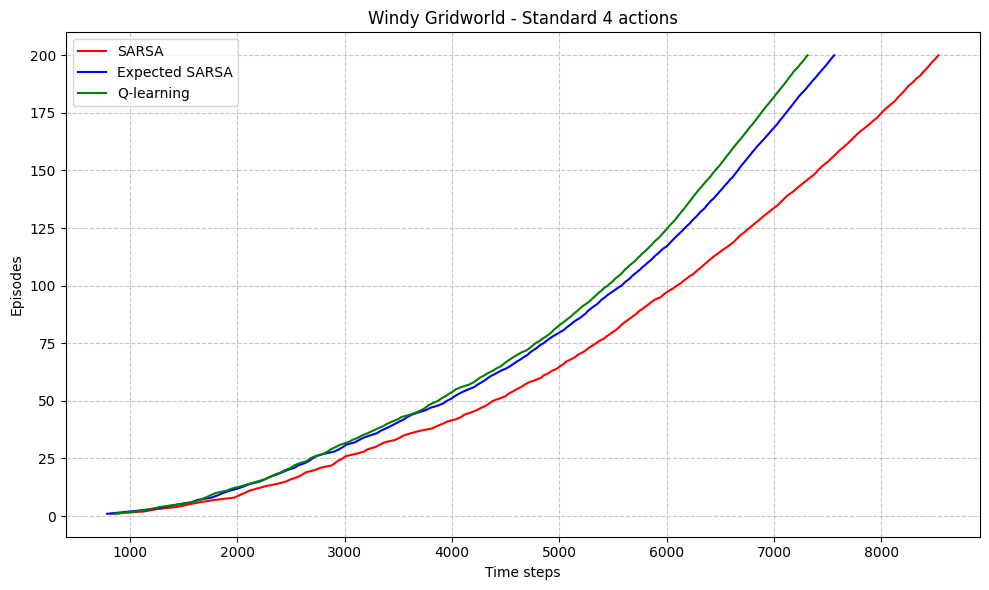

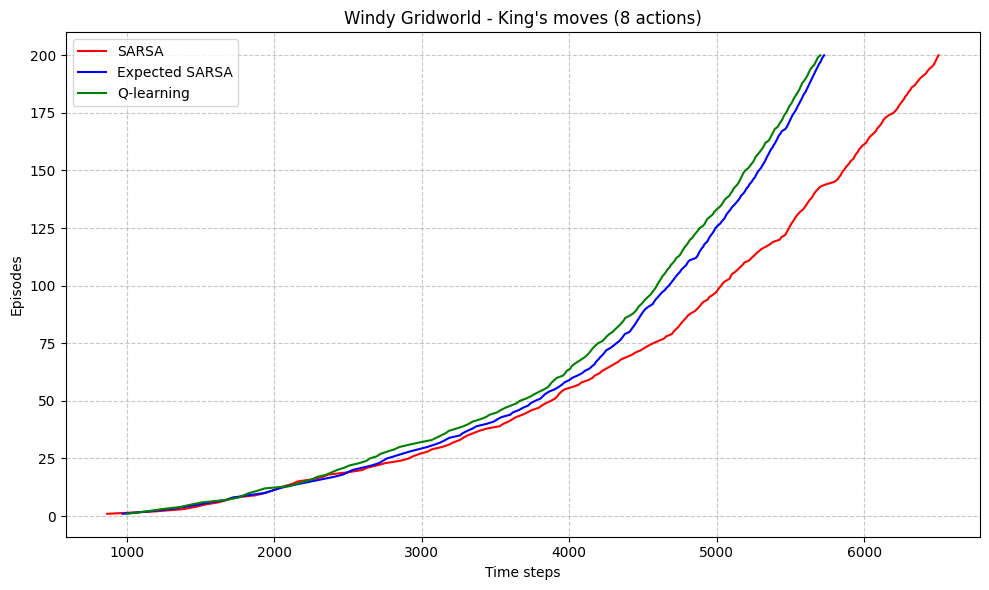

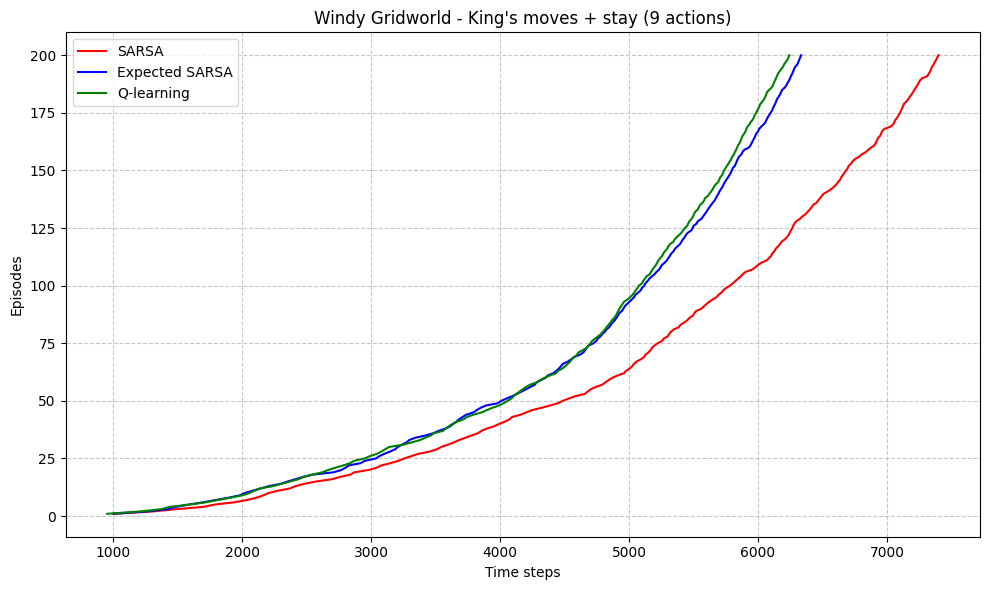

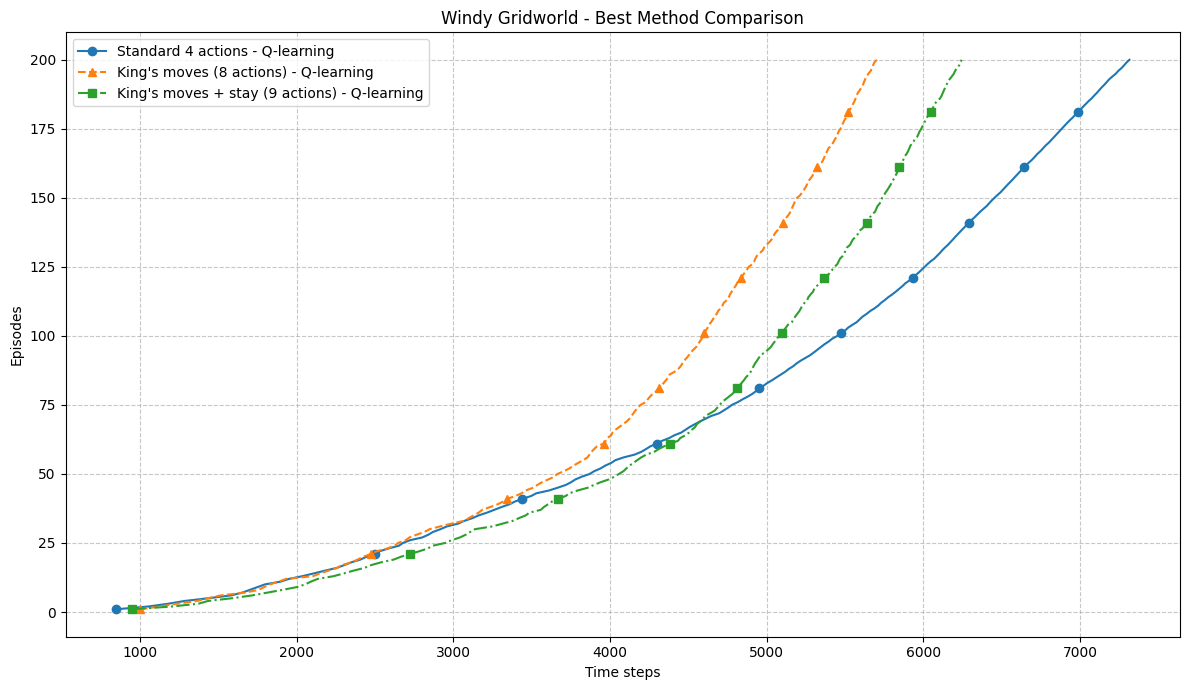

In [119]:
run_td_method_comparison(run_num=3, max_steps=16000)

In [120]:
class StochasticWindyGridWorld(WindyGridWorld):
    def __init__(self, enable_king_move=False, enable_no_move=False):
        """
        Stochastic Windy GridWorld:
            - Like regular Windy GridWorld but with stochastic wind:
              1/3 chance: normal wind strength
              1/3 chance: wind strength + 1
              1/3 chance: wind strength - 1
        """
        super().__init__(enable_king_move, enable_no_move)
    
    def step(self, act_key):
        """
        Takes a step with stochastic wind effect.
        """
        # Record the chosen action key
        self.act = act_key

        # Get the shift from the action space
        shift = self.action_space[act_key]

        # 1) Move according to the chosen action
        next_r = self.state[0] + shift[0]
        next_c = self.state[1] + shift[1]

        # 2) Apply stochastic wind
        wind_strength = self.wind[self.state[1]]
        
        # Randomly modify wind strength
        rand_val = np.random.random()
        if rand_val < 1/3:
            # Normal wind strength (no change)
            pass
        elif rand_val < 2/3:
            # Wind strength + 1
            wind_strength += 1
        else:
            # Wind strength - 1
            wind_strength -= 1

        # Apply wind effect (upward shift)
        next_r -= wind_strength

        # 3) Clip to grid boundaries
        max_r, max_c = self.grid.shape
        next_r = max(0, min(next_r, max_r - 1))
        next_c = max(0, min(next_c, max_c - 1))

        # Update the state
        self.state = [next_r, next_c]

        # Check if we reached the goal
        terminated = (self.state == self.goal_state)

        # Typical reward scheme: -1 per step, 0 upon reaching goal
        reward = 0.0 if terminated else -1.0

        self.t += 1
        return self.state, reward, terminated


In [121]:
def run_stochastic_wind_comparison(run_num=3, max_steps=16000):
    """
    Compare the three TD methods (SARSA, Expected SARSA, Q-learning) 
    with King's moves in the stochastic wind environment.
    """
    # Set random seeds for reproducibility
    np.random.seed(1234)
    random.seed(1234)
    
    # Parameters
    num_episodes = 200
    epsilon = 0.1
    alpha = 0.5
    gamma = 1.0
    timeout = 1000
    
    # Only using King's moves for this comparison
    enable_king_move = True
    enable_no_move = False
    
    # Initialize algorithms
    algorithms = [
        {"name": "SARSA", "class": SARSA, "color": "r"},
        {"name": "Expected SARSA", "class": ExpectedSARSA, "color": "b"},
        {"name": "Q-learning", "class": QLearning, "color": "g"}
    ]
    
    # Track results
    all_results = {}
    
    print("\n--- Stochastic Wind with King's Moves ---")
    
    # Run each algorithm
    for algo in algorithms:
        print(f"  Running {algo['name']}...")
        algo_results = []
        
        for run in range(run_num):
            print(f"    Run {run+1}/{run_num}")
            env = StochasticWindyGridWorld(enable_king_move=enable_king_move, 
                                           enable_no_move=enable_no_move)
            controller = algo['class'](env, alpha, epsilon, gamma, timeout)
            steps_per_episode = controller.run(num_episodes)
            algo_results.append(steps_per_episode)
        
        all_results[algo['name']] = algo_results
    
    # Print performance summary
    print("\n=== Performance Summary ===")
    print("Average steps in episodes 90-100:")
    
    for algo_name, algo_results in all_results.items():
        late_steps = np.mean([r[90:100] for r in algo_results if len(r) >= 100])
        print(f"  {algo_name}: {late_steps:.2f}")
    
    # Plot results
    plt.figure(figsize=(10, 6))
    
    for algo in algorithms:
        algo_name = algo['name']
        results_array = np.array(all_results[algo_name])
        
        # Handle NaN values
        avg_results = np.nanmean(results_array, axis=0)
        
        # Replace NaN values with the last valid value
        last_valid = 0
        for j in range(len(avg_results)):
            if np.isnan(avg_results[j]):
                avg_results[j] = last_valid
            else:
                last_valid = avg_results[j]
        
        # Convert steps per episode to cumulative steps and episodes
        cum_steps = np.cumsum(avg_results)
        episodes = np.arange(1, len(cum_steps) + 1)
        
        # Clip to max_steps
        mask = cum_steps <= max_steps
        if np.any(mask):
            plt.plot(cum_steps[mask], episodes[mask], color=algo['color'], label=algo_name)
    
    plt.xlabel('Time steps')
    plt.ylabel('Episodes')
    plt.title('Stochastic Windy Gridworld with King\'s Moves')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Additional comparison: Deterministic vs Stochastic Wind
    plt.figure(figsize=(12, 7))
    markers = ['o', 's', '^']
    linestyles = ['-', '--']
    
    # First find the best algorithm in stochastic environment
    best_algo = None
    best_perf = float('inf')
    
    for algo_name, algo_results in all_results.items():
        late_steps = np.mean([r[90:100] for r in algo_results if len(r) >= 100])
        if late_steps < best_perf:
            best_perf = late_steps
            best_algo = algo_name
    
    print(f"\nBest algorithm in stochastic environment: {best_algo}")
    
    # Plot the best stochastic algorithm
    results_array = np.array(all_results[best_algo])
    avg_results = np.nanmean(results_array, axis=0)
    
    # Replace NaN values
    last_valid = 0
    for j in range(len(avg_results)):
        if np.isnan(avg_results[j]):
            avg_results[j] = last_valid
        else:
            last_valid = avg_results[j]
    
    cum_steps = np.cumsum(avg_results)
    episodes = np.arange(1, len(cum_steps) + 1)
    
    mask = cum_steps <= max_steps
    if np.any(mask):
        plt.plot(
            cum_steps[mask], 
            episodes[mask], 
            linestyle=linestyles[0],
            marker=markers[0],
            markevery=max(1, len(cum_steps[mask]) // 10),
            label=f"Stochastic Wind - {best_algo}",
        )
    
    # Now run the same algorithm in the deterministic environment
    print(f"\nRunning {best_algo} in deterministic environment for comparison...")
    det_results = []
    
    for run in range(run_num):
        print(f"  Run {run+1}/{run_num}")
        env = WindyGridWorld(enable_king_move=enable_king_move, 
                             enable_no_move=enable_no_move)
        
        # Get the correct algorithm class
        best_algo_class = None
        for algo in algorithms:
            if algo['name'] == best_algo:
                best_algo_class = algo['class']
                break
        
        controller = best_algo_class(env, alpha, epsilon, gamma, timeout)
        steps_per_episode = controller.run(num_episodes)
        det_results.append(steps_per_episode)
    
    # Plot the deterministic results
    results_array = np.array(det_results)
    avg_results = np.nanmean(results_array, axis=0)
    
    # Replace NaN values
    last_valid = 0
    for j in range(len(avg_results)):
        if np.isnan(avg_results[j]):
            avg_results[j] = last_valid
        else:
            last_valid = avg_results[j]
    
    cum_steps = np.cumsum(avg_results)
    episodes = np.arange(1, len(cum_steps) + 1)
    
    mask = cum_steps <= max_steps
    if np.any(mask):
        plt.plot(
            cum_steps[mask], 
            episodes[mask], 
            linestyle=linestyles[1],
            marker=markers[1],
            markevery=max(1, len(cum_steps[mask]) // 10),
            label=f"Deterministic Wind - {best_algo}",
        )
    
    # Complete the plot
    plt.xlabel('Time steps')
    plt.ylabel('Episodes')
    plt.title('Comparison: Stochastic vs Deterministic Wind')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


--- Stochastic Wind with King's Moves ---
  Running SARSA...
    Run 1/3
    Run 2/3
    Run 3/3
  Running Expected SARSA...
    Run 1/3
    Run 2/3
    Run 3/3
  Running Q-learning...
    Run 1/3
    Run 2/3
    Run 3/3

=== Performance Summary ===
Average steps in episodes 90-100:
  SARSA: 102.00
  Expected SARSA: 86.73
  Q-learning: 78.03


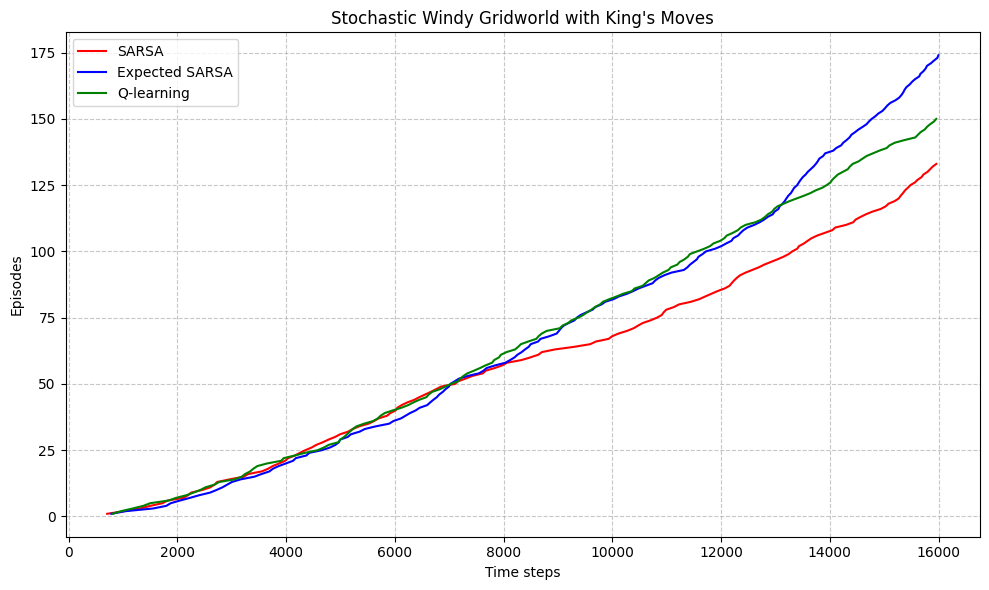


Best algorithm in stochastic environment: Q-learning

Running Q-learning in deterministic environment for comparison...
  Run 1/3
  Run 2/3
  Run 3/3


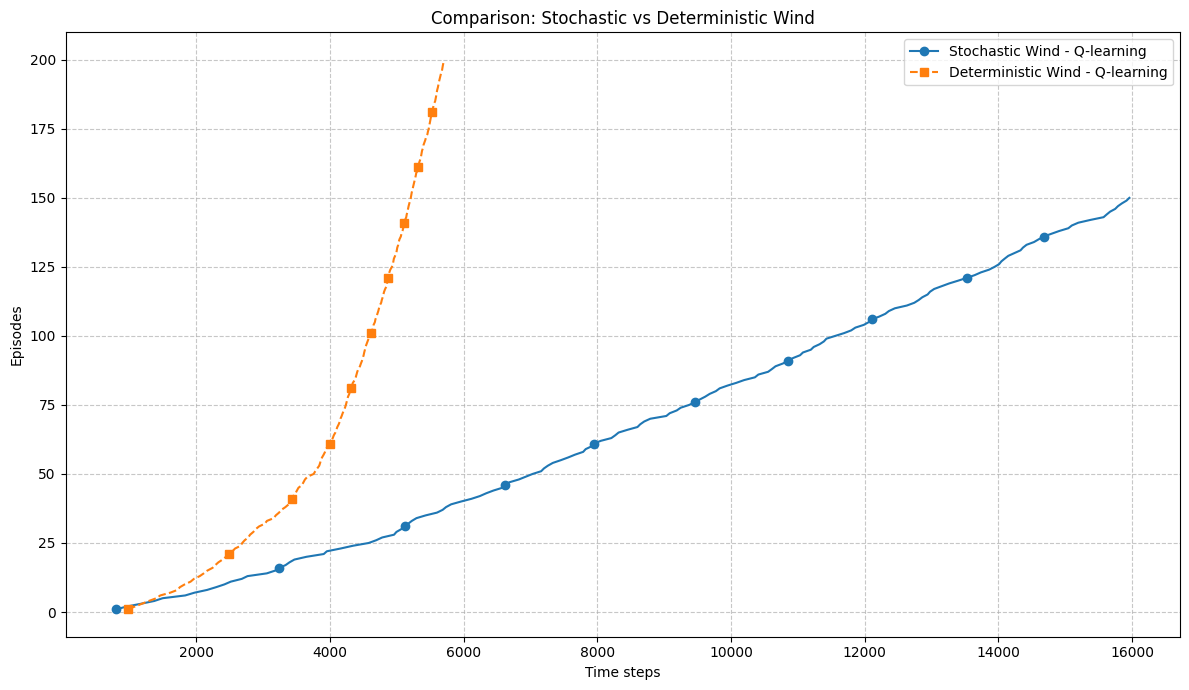

In [122]:
# Run the stochastic wind experiment
run_stochastic_wind_comparison(run_num=3, max_steps=16000)

# Question 4
- Please refer to starter code from question 4 to help you get started. You will create your own TD(0) and Monte Carlo classes.
- We will continue with the original windy gridworld domain. 
- A fixed policy π will be specified to collect episodes.
- A certain number of “training” episodes N ∈ {1, 10, 50} will be collected.
- Each method being investigated ( On-policy TD(0), On-policy Monte-Carlo prediction) will learn to      estimate the state-value.
function using the N “training“ episodes, respectively.
- We then evaluate the distribution of learning targets each method experiences at a specified state S. In
this question, S is the initial state marked as S in the Example 6.5.
- To do so, you need to collect additional 100 “evaluation” episodes. Instead of using these to perform
further updates to the state-value function, we will instead evaluate the distribution of learning targets
V(S) based on the “evaluation” episodes. For example, TD(0) will experience a set of {R+ V(S′)} targets,
whereas Monte-Carlo will experience a set of {G} targets.
- Note that in practice you should pre-collect both the training and evaluation episodes for efficiency and to
ensure consistency while comparing between different methods.

In [123]:
def run_on_policy_mc_td_epsilon_greedy_windy_gridworld():
    enable_king_move_actions = False
    enable_no_move_actions = False
    
    # Create environment
    env = WindyGridWorld(enable_king_move=enable_king_move_actions,
                         enable_no_move=enable_no_move_actions)
    
    # Parameters
    alpha = 0.5
    epsilon = 0.1
    gamma = 1.0
    timeout = 1000
    num_episodes = 500  # Episodes to train a near-optimal policy
    
    print("Training a near-optimal policy using SARSA...")
    
    # Train a near-optimal policy using SARSA
    sarsa_agent = SARSA(env, alpha, epsilon, gamma, timeout)
    sarsa_agent.run(num_episodes)
    
    # Get the learned Q-values for greedy policy extraction
    q_values = sarsa_agent.Q
    
    # Create a slightly stochastic policy (epsilon=0.05) based on the learned Q-values
    def policy(state):
        s_idx = sarsa_agent._state_to_index(state)
        
        if np.random.rand() < 0.05:  # Small epsilon for some exploration
            action_idx = np.random.choice(len(sarsa_agent.actions))
        else:
            action_idx = np.argmax(q_values[s_idx])
            
        return sarsa_agent.actions[action_idx]
    
    # State for evaluation (start state)
    start_state = env.start_state
    
    # Collect episodes for training and evaluation
    print("Collecting episodes for training and evaluation...")
    training_episodes_1 = collect_episodes(env, policy, 1, timeout)
    training_episodes_10 = collect_episodes(env, policy, 10, timeout)
    training_episodes_50 = collect_episodes(env, policy, 50, timeout)
    evaluation_episodes = collect_episodes(env, policy, 100, timeout)  # 100 evaluation episodes
    
    # Run TD(0) and MC prediction with different numbers of training episodes
    print("Running TD(0) and MC prediction...")
    training_sets = {
        "1 Episode": training_episodes_1,
        "10 Episodes": training_episodes_10,
        "50 Episodes": training_episodes_50
    }
    
    td_values = {}
    mc_values = {}
    
    for name, training_episodes in training_sets.items():
        # TD(0) prediction
        td_value_function = td0_prediction(env, training_episodes, gamma, alpha)
        td_values[name] = td_value_function
        
        # MC prediction
        mc_value_function = mc_prediction(env, training_episodes, gamma, alpha)
        mc_values[name] = mc_value_function
    
    # Evaluate learning targets on evaluation episodes
    print("Evaluating learning targets...")
    
    td_targets = {}
    mc_targets = {}
    
    for name in training_sets.keys():
        # TD(0) learning targets for the start state
        td_targets[name] = evaluate_td0_targets(env, evaluation_episodes, gamma, td_values[name], start_state)
        
        # MC learning targets for the start state
        mc_targets[name] = evaluate_mc_targets(env, evaluation_episodes, gamma, start_state)
    
    # Plot histograms
    plot_target_histograms(td_targets, mc_targets)

def collect_episodes(env, policy, num_episodes, timeout):
    """
    Collect episodes following the given policy.
    Returns a list of episodes, where each episode is a list of (state, action, reward, next_state) tuples.
    """
    episodes = []
    
    for _ in range(num_episodes):
        episode = []
        state, _ = env.reset()
        steps = 0
        
        while steps < timeout:
            action = policy(state)
            next_state, reward, terminated = env.step(action)
            
            episode.append((state, action, reward, next_state))
            
            if terminated:
                break
                
            state = next_state
            steps += 1
            
        episodes.append(episode)
    
    return episodes

def td0_prediction(env, episodes, gamma, alpha):
    """
    TD(0) prediction algorithm.
    """
    # Initialize V(s) to 0 for all states
    V = np.zeros(len(env.state_space))
    
    for episode in episodes:
        for t, (state, _, reward, next_state) in enumerate(episode):
            # Convert states to indices
            s_idx = env.state_space.index(state)
            s_next_idx = env.state_space.index(next_state)
            
            # TD update
            td_target = reward + gamma * V[s_next_idx]
            td_error = td_target - V[s_idx]
            V[s_idx] += alpha * td_error
    
    return V

def mc_prediction(env, episodes, gamma, alpha):
    """
    Monte Carlo prediction algorithm.
    """
    # Initialize V(s) to 0 for all states
    V = np.zeros(len(env.state_space))
    returns_count = np.zeros(len(env.state_space))
    
    for episode in episodes:
        G = 0
        
        # Process the episode in reverse order
        for t in reversed(range(len(episode))):
            state, _, reward, _ = episode[t]
            s_idx = env.state_space.index(state)
            
            # Update return
            G = gamma * G + reward
            
            # Incremental update
            returns_count[s_idx] += 1
            V[s_idx] += (G - V[s_idx]) / returns_count[s_idx]
    
    return V

def evaluate_td0_targets(env, episodes, gamma, V, target_state):
    """
    Evaluate TD(0) learning targets for a specific state across episodes.
    """
    targets = []
    target_state_idx = env.state_space.index(target_state)
    
    for episode in episodes:
        for t, (state, _, reward, next_state) in enumerate(episode):
            if state == target_state:
                s_next_idx = env.state_space.index(next_state)
                td_target = reward + gamma * V[s_next_idx]
                targets.append(td_target)
    
    return targets

def evaluate_mc_targets(env, episodes, gamma, target_state):
    """
    Evaluate Monte Carlo learning targets (returns) for a specific state across episodes.
    """
    targets = []
    
    for episode in episodes:
        for t, (state, _, _, _) in enumerate(episode):
            if state == target_state:
                # Calculate return from this point onwards
                G = 0
                for i in range(t, len(episode)):
                    _, _, r, _ = episode[i]
                    G += gamma**(i-t) * r
                
                targets.append(G)
    
    return targets

def plot_target_histograms(td_targets, mc_targets):
    """
    Plot histograms of learning targets for TD(0) and MC.
    """
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle('Bias-Variance Trade-off: TD(0) vs Monte Carlo Learning Targets', fontsize=16)
    
    training_sizes = ["1 Episode", "10 Episodes", "50 Episodes"]
    
    for i, size in enumerate(training_sizes):
        # TD(0) targets
        td_data = td_targets[size]
        axes[i, 0].hist(td_data, bins=20, alpha=0.7, color='b')
        axes[i, 0].set_title(f'TD(0) with {size}')
        axes[i, 0].set_xlabel('Learning Target Value')
        axes[i, 0].set_ylabel('Frequency')
        axes[i, 0].axvline(np.mean(td_data), color='r', linestyle='dashed', linewidth=1)
        axes[i, 0].text(0.7, 0.9, f'Mean: {np.mean(td_data):.2f}\nStd: {np.std(td_data):.2f}', 
                         transform=axes[i, 0].transAxes, bbox=dict(facecolor='white', alpha=0.5))
        
        # MC targets
        mc_data = mc_targets[size]
        axes[i, 1].hist(mc_data, bins=20, alpha=0.7, color='g')
        axes[i, 1].set_title(f'Monte Carlo with {size}')
        axes[i, 1].set_xlabel('Learning Target Value')
        axes[i, 1].set_ylabel('Frequency')
        axes[i, 1].axvline(np.mean(mc_data), color='r', linestyle='dashed', linewidth=1)
        axes[i, 1].text(0.7, 0.9, f'Mean: {np.mean(mc_data):.2f}\nStd: {np.std(mc_data):.2f}', 
                         transform=axes[i, 1].transAxes, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


Training a near-optimal policy using SARSA...
Running TD(0) and MC prediction...
Evaluating learning targets...


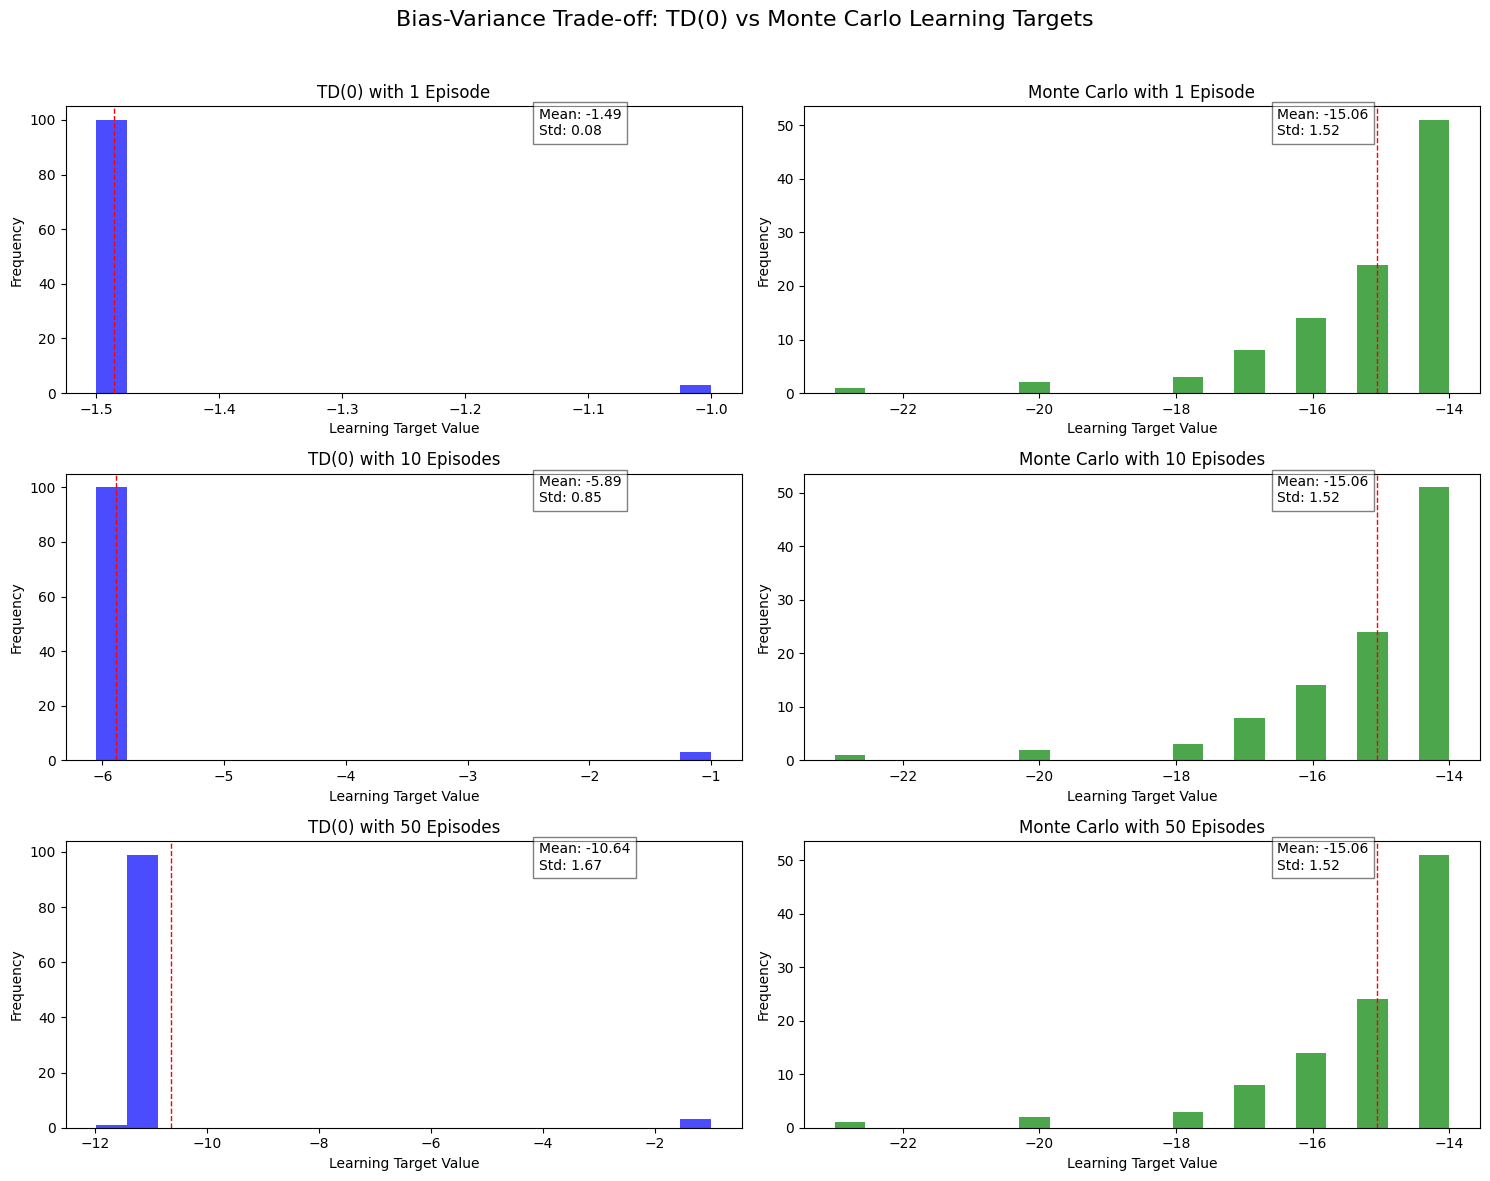

In [124]:
if __name__ == "__main__":
    np.random.seed(1234)
    random.seed(1234)
    run_on_policy_mc_td_epsilon_greedy_windy_gridworld()